# HARP Rater offset overhead testing

The aim of this notebook is to take the output from the ompsql search converted to a csv file and plot images of the maps

The table used here is created by using ompsql:

> ompsql

> use jcmt;

> select project, c.obsid, c.utdate, FORMAT(c.elstart,1) as ELSTART, c.map_wdth, TIMESTAMPDIFF(SECOND,c.date_obs,c.date_end)/60 as DURATION,a.skyrefx, a.skyrefy from COMMON as c left join ACSIS as a on (c.obsid=a.obsid) where c.project="m17aec07" or c.project="m18bec07";

and then using sed on the command line:

> /Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting

> sed 's/|/,/g;s/+/,/g;s/-//g' off-test-data.txt > off-test-data.csv

> sed -i '' '/NULL/d' off-test-data.csv

or if data stright from ompsql script:

>  sed -i '' '/NULL/d' off-test-data.txt

note the last command is for mac user otherwise simply use

> sed -i '/NULL/d' off-test-data.csv 

Weirdly:
skyrefx seems to relate to the Dec and b of the offset location
skyrefy seems to relate to the RA and l of the offset location

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column, Row, join, vstack
from astropy.io import ascii

%matplotlib inline

# Expected elapsed time from Hedwig ITC using

From:

https://github.com/eaobservatory/python-jcmt_itc_heterodyne/blob/master/lib/jcmt_itc_heterodyne/itc.py

Saved:

> /Users/hparsons/software/python-jcmt_itc_heterodyne/lib/jcmt_itc_heterodyne/

nice and simple - four examples used as follows:

1. 300” x 300” 1/4 array sample time 0.5 seconds, OT time =  00:11:03.0, Hedwig = 0:10:56 = 10.93
2. 900” x 900” 1 array sample time 0.4 seconds, OT time =  00:12:17.6, Hedwig = 0:12:17 = 12.28
3. 1800” x 1800” 1 array sample time 0.1 seconds, OT time =  00:14:00.5, Hedwig = 0:14:00 = 14.0
4. 3600” x 3600” 1 array sample time 0.1 seconds, OT time =  00:39:34.7, Hedwig = 0:39:38 = 39.63

To do this we have deined two functions. 

i) Create_expected_time_python_script: This makes a python file to run to obtain the expected elapsed time given the map size, sampel time and array spacing. 

ii) Get_Expeted_Elapsed: This takes the output from Create_expected_time_python_script and runs the created file in python to obtain the predicted elapsed time. 

In [2]:
def Create_expected_time_python_script (input_int_time, input_dim_w, input_dim_h, input_dy):
    '''function to produce file needed to get expected time
    from https://github.com/eaobservatory/python-jcmt_itc_heterodyne/blob/master/lib/jcmt_itc_heterodyne/itc.py
    input required: 
    i) integration time per point
    ii) map width dimension in arcseconds
    iii) map hight dimension in arcseconds
    iv) map dy (map spacing correcspoding to array soacing 
    i.e. single array spacing = 116.4171)
    Note all inputs to be provided in string format
    '''

    filepathforpython = "/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/ITC/"
    filenameforpython = "expected_time_script"+input_dim_w+"_"+input_dim_h+"_"+input_int_time+"_"+input_dy+".py"
    output1 = filepathforpython+filenameforpython
#     print (output1)

    l1 = "from jcmt_itc_heterodyne import HeterodyneITC, HeterodyneReceiver \n"
    l2 = "itc = HeterodyneITC()\n"
    l3 = "(rms, extra) = itc.calculate_rms_for_int_time( \n"
    l4 = "    int_time="+input_int_time +", \n"
    l5 = "    receiver=HeterodyneReceiver.HARP, \n"
    l6 = "    map_mode=HeterodyneITC.RASTER, \n"
    l7 = "    sw_mode=HeterodyneITC.PSSW, \n"
    l8 = "    freq=345.796, \n"
    l9 = "    freq_res=0.488, \n"
    l10 = "    tau_225=0.1, \n"
    l11 = "    zenith_angle_deg=32.353, \n"
    l12 = "    is_dsb=False, \n"
    l13 = "    dual_polarization=False, \n"
    l14 = "    n_points=None, \n"
    l15 = "    dim_x="+input_dim_w+", \n"
    l16 = "    dim_y="+input_dim_h+", \n"
    l17 = "    dx=7.27, \n" # fixed for rasters
    l18 = "    dy="+input_dy+", \n"
    l19 = "    basket_weave=False, \n"
    l20 = "    separate_offs=None, \n"
    l21 = "    continuum_mode=False, \n"
    l22 = "    with_extra_output=True) \n"
    l23 = "from pprint import pprint \n"
    l24 = "print(rms) \n"
    l25 = "pprint(extra) \n"

    fo = open(output1, "w")
    fo.writelines([l1, l2, l3, l4,l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17, l18, l19, l20, l21, l22, l23, l24, l25])
    
    return (output1)
    fo.close()

    
def Get_Expeted_Elapsed (hetitcfiletorun):
    '''This'''
    import subprocess
    output2 = (subprocess.getoutput('python '+hetitcfiletorun))

    # print (output2)

    x = 0
    for y in (output2.split(":")):
        if x ==1:
#             print (x,y)
            for z in (y.split(",")):
                break
        x = x+1
    
    expected_elapsed_time = float(z)/60
    return (expected_elapsed_time)
 

# Bug in code:

If x and y offpositon is specified as relative offsets in arcseconds 
then the system computer the RA and DEC positon and so reports back the actual position in RA and DEC

# Files of interest


In [3]:
file = "/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/off-test-data.txt" # if on my mac
projname = 'ec07'


# ALTERNATIVELY RUN WITH:

file = "/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/m17bl004-off-data.txt" # if on my mac
projname = 'm17bl004'

In [4]:
data = ascii.read(file)
# print (data.info())
# print (data.keys())
# data.show_in_notebook()

In [5]:
# before we go any further I should remove the rows that I know contain split observations
# observations: 40 & 41 42 & 43,  48 & 49 

if projname == 'ec07':
  data.remove_rows([40,41,42,43,48,49])
  print ('manually removing selected rows from ec07 data associated with split observations')

    


data.show_in_notebook()

idx,project,utdate,obsnum,ELSTART,map_wdth,map_hght,DURATION,skyrefx,skyrefy,scan_dy,scan_vel,scan_pa,steptime,molecule,object,WVMTAUST,WVMTAUEN
0,M17BL004,20170624,49,38.3,300,300,4.6833,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,0,0.125,CO,0.0+0.0,0.101,0.1
1,M17BL004,20170624,50,37.8,300,300,4.7,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,90,0.125,CO,0.0+0.0,0.1,0.101
2,M17BL004,20170624,51,37.3,300,300,3.9333,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,0,0.25,CO,0.0+0.0,0.101,0.102
3,M17BL004,20170624,52,36.9,300,300,3.9167,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,90,0.25,CO,0.0+0.0,0.101,0.1
4,M17BL004,20170629,50,34.3,300,300,4.6833,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,0,0.125,No Line,00.0+0.0,0.078,0.079
5,M17BL004,20170629,50,34.3,300,300,4.6833,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,0,0.125,No Line,00.0+0.0,0.078,0.079
6,M17BL004,20170629,51,33.6,300,300,4.6167,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,90,0.125,No Line,00.0+0.0,0.079,0.08
7,M17BL004,20170629,51,33.6,300,300,4.6167,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,90,0.125,No Line,00.0+0.0,0.079,0.08
8,M17BL004,20170629,52,32.9,300,300,3.85,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,0,0.25,No Line,0.0+0.0,0.079,0.08
9,M17BL004,20170629,52,32.9,300,300,3.85,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,0,0.25,No Line,0.0+0.0,0.079,0.08


In [6]:
if projname == 'ec07':
    datafile = data
    print ('working on ec07 data')

    
if projname == 'm17bl004':
    dataselected1 = data[data['map_wdth']==1260]
    datafile = dataselected1[dataselected1['molecule']=='CO']
#     datafile = dataselected1[dataselected1['scan_dy']==58.2086]
    print ('working on m17bl004')

datafile = data
    
# if projname == 'm17bl004':
#     dataselected1 = data[data['map_wdth']>400]
#     datafile = dataselected1[dataselected1['molecule']=='CO']
# #     datafile = dataselected1[dataselected1['object'].startswith('12CO')]
#     print ('working on m17bl004')

working on m17bl004


In [7]:
# datafile.show_in_notebook()

In [8]:
coords = Column([y.split("]")[0] for y in ([x.split("[")[2] for x in datafile['skyrefx']])], name="coordpart")
offsetx = Column([float(z) for z in [y.split("[")[0] for y in ([x.split("]")[1] for x in datafile['skyrefx']])]], name="offsetx",dtype=int)
offsety = Column([float(z) for z in [y.split("[")[0] for y in ([x.split("]")[1] for x in datafile['skyrefy']])]], name="offsety",dtype=int)


In [9]:
# datafile.add_columns([coords,offsetx,offsety,duration_int,el_int,size_int,scan_dy_int,scan_vel_int,steptime_int])
datafile.add_columns([coords,offsetx,offsety])

In [10]:
offset = Column([((x['offsetx']**2.0) + (x['offsety']**2.0))**0.5 for x in datafile], name='offset')
datafile.add_columns([offset])

In [11]:
# datafile.show_in_notebook()

In [12]:
newcolumn1 = []
newcolumn2 = []
newcolumn3 = []
newcolumn4 = []


for x in datafile:
    outfileproduced = Create_expected_time_python_script(str(x['steptime']), str(x['map_wdth']), str(x['map_hght']), str(x['scan_dy']))
    exposure_time_expected = Get_Expeted_Elapsed(outfileproduced)
    fraction_of_time = x['DURATION']/exposure_time_expected
        
    newcolumn1.append(exposure_time_expected)
    newcolumn2.append(fraction_of_time)
    
    scan_length = 0
    if  x['scan_pa'] == 0:
        scan_length = x['map_wdth']    
    if x['scan_pa'] == 90:
        scan_length = x['map_hght']

    newcolumn3.append(scan_length)
    
    number_of_rows = np.ceil(scan_length / x['scan_dy'])
    newcolumn4.append(number_of_rows)

exposure_time_column = Column(newcolumn1,name="Expected_Exposure_time") 
fraction_of_time_column = Column(newcolumn2,name="Time_Fraction") 
scan_length_column = Column(newcolumn3,name="Scan_Length") 
number_of_rows_column = Column(newcolumn4, name="noRows")

# now I want to add this new quantity back into my table



In [13]:
datafile.add_columns([exposure_time_column,fraction_of_time_column,scan_length_column,number_of_rows_column])

In [14]:
datafile.show_in_notebook()

idx,project,utdate,obsnum,ELSTART,map_wdth,map_hght,DURATION,skyrefx,skyrefy,scan_dy,scan_vel,scan_pa,steptime,molecule,object,WVMTAUST,WVMTAUEN,coordpart,offsetx,offsety,offset,Expected_Exposure_time,Time_Fraction,Scan_Length,noRows
0,M17BL004,20170624,49,38.3,300,300,4.6833,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,0,0.125,CO,0.0+0.0,0.101,0.1,GAL,2800,-10000,10384.603988597735,6.212212873693184,0.7538859493743911,300,11.0
1,M17BL004,20170624,50,37.8,300,300,4.7,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,90,0.125,CO,0.0+0.0,0.1,0.101,GAL,2800,-10000,10384.603988597735,6.212212873693184,0.7565742023913988,300,11.0
2,M17BL004,20170624,51,37.3,300,300,3.9333,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,0,0.25,CO,0.0+0.0,0.101,0.102,GAL,2800,-10000,10384.603988597735,4.8557473773622615,0.810029784155832,300,6.0
3,M17BL004,20170624,52,36.9,300,300,3.9167,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,90,0.25,CO,0.0+0.0,0.101,0.1,GAL,2800,-10000,10384.603988597735,4.8557473773622615,0.8066111549088926,300,6.0
4,M17BL004,20170629,50,34.3,300,300,4.6833,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,0,0.125,No Line,00.0+0.0,0.078,0.079,GAL,2800,-10000,10384.603988597735,6.212212873693184,0.7538859493743911,300,11.0
5,M17BL004,20170629,50,34.3,300,300,4.6833,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,0,0.125,No Line,00.0+0.0,0.078,0.079,GAL,2800,-10000,10384.603988597735,6.212212873693184,0.7538859493743911,300,11.0
6,M17BL004,20170629,51,33.6,300,300,4.6167,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,90,0.125,No Line,00.0+0.0,0.079,0.08,GAL,2800,-10000,10384.603988597735,6.212212873693184,0.7431651319532704,300,11.0
7,M17BL004,20170629,51,33.6,300,300,4.6167,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],29.1043,58.2088,90,0.125,No Line,00.0+0.0,0.079,0.08,GAL,2800,-10000,10384.603988597735,6.212212873693184,0.7431651319532704,300,11.0
8,M17BL004,20170629,52,32.9,300,300,3.85,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,0,0.25,No Line,0.0+0.0,0.079,0.08,GAL,2800,-10000,10384.603988597735,4.8557473773622615,0.7928748554648649,300,6.0
9,M17BL004,20170629,52,32.9,300,300,3.85,[OFFSET] 2800 [GAL],[OFFSET] -10000 [GAL],58.2086,29.1044,0,0.25,No Line,0.0+0.0,0.079,0.08,GAL,2800,-10000,10384.603988597735,4.8557473773622615,0.7928748554648649,300,6.0


In [15]:
print (np.median(datafile['Time_Fraction']))
print (np.mean(datafile['Time_Fraction']))

1.0726907517289102
1.0522499591449102


# Making Generic Paramater Space plots

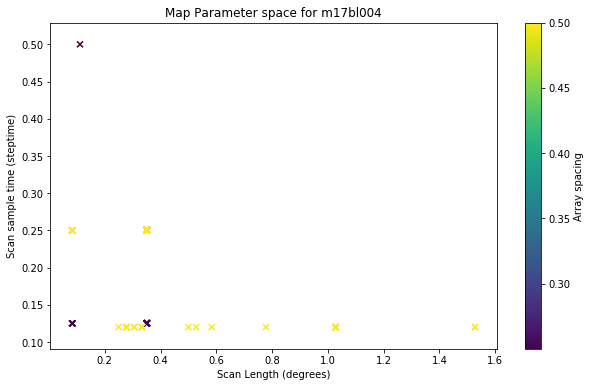

In [16]:
# Plotting a figure of the map type parameter space
# Note: single array is spaced by 1164171

plt.figure(figsize=(10,6))

plt.scatter(datafile['Scan_Length']/60/60, datafile['steptime'], marker='x',c=datafile['scan_dy']/116.4171) 
plt.xlabel('Scan Length (degrees)')
plt.ylabel('Scan sample time (steptime)')
plt.title('Map Parameter space for '+projname)
cb = plt.colorbar()
cb.set_label('Array spacing')

plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-size-sample-array.pdf')
plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-size-sample-array.png')

plt.show()

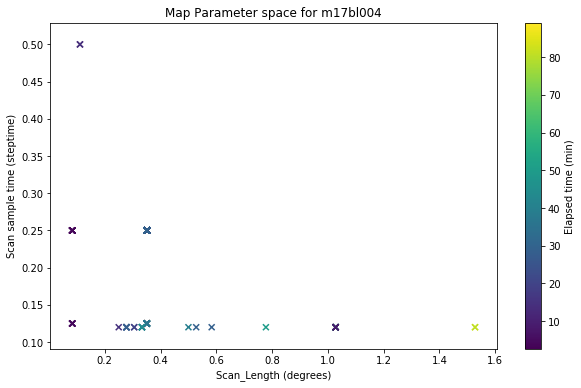

In [17]:
plt.figure(figsize=(10,6))

plt.scatter(datafile['Scan_Length']/60/60, datafile['steptime'], marker='x',c=datafile['DURATION'])#c=datafile['scan_dy_int']/116.4171) 
plt.xlabel('Scan_Length (degrees)')
plt.ylabel('Scan sample time (steptime)')
plt.title('Map Parameter space for '+projname)
cb = plt.colorbar()
cb.set_label('Elapsed time (min)')

plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-size-sample-time.pdf')
plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-size-sample-time.png')

plt.show()

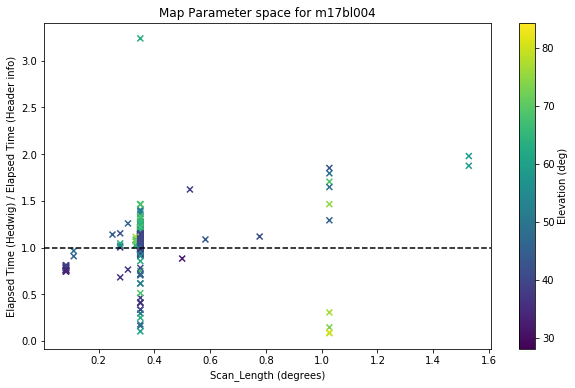

In [18]:
plt.figure(figsize=(10,6))

plt.scatter(datafile['Scan_Length']/60/60, datafile['Time_Fraction'], marker='x',c=datafile['ELSTART'])#c=datafile['scan_dy_int']/116.4171) 
plt.xlabel('Scan_Length (degrees)')
plt.ylabel('Elapsed Time (Hedwig) / Elapsed Time (Header info)')
plt.title('Map Parameter space for '+projname)
cb = plt.colorbar()
cb.set_label('Elevation (deg)')

plt.axhline(y=1, color='k', linestyle='--')

plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-size-frac-el.pdf')
plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-size-frac-el.png')


plt.show()

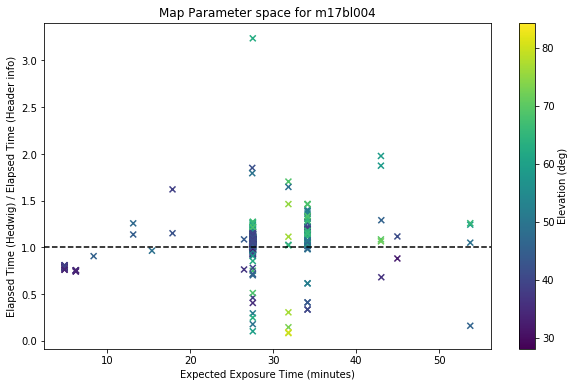

In [19]:
plt.figure(figsize=(10,6))

plt.scatter(datafile['Expected_Exposure_time'], datafile['Time_Fraction'], marker='x',c=datafile['ELSTART'])#c=datafile['scan_dy_int']/116.4171) 
plt.xlabel('Expected Exposure Time (minutes)')
plt.ylabel('Elapsed Time (Hedwig) / Elapsed Time (Header info)')
plt.title('Map Parameter space for '+projname)
cb = plt.colorbar()
cb.set_label('Elevation (deg)')

plt.axhline(y=1, color='k', linestyle='--')

plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-time-frac-el.pdf')
plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-time-frac-el.png')


plt.show()

In [20]:
# plt.figure(figsize=(10,6))
# plt.hist(datafile['Time_Fraction'], bins=50)
# plt.xlabel('Elapsed Time (Hedwig) / Elapsed Time (Header info)')
# plt.axvline(x=np.median(datafile['Time_Fraction']), color='yellow', linestyle='--')

# plt.legend()



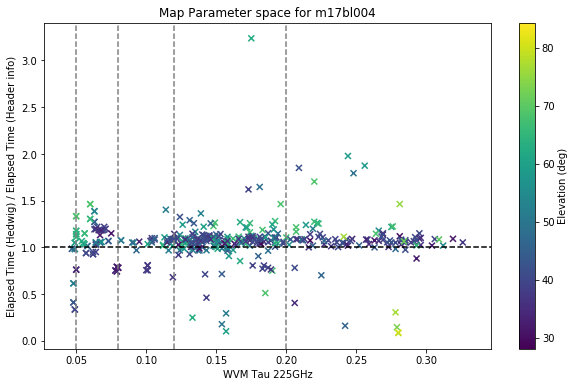

In [21]:
if projname == 'm17bl004': # only plot for real project data (not E&C which can be closed dome)

    plt.figure(figsize=(10,6))

    plt.scatter(datafile['WVMTAUST'], datafile['Time_Fraction'], marker='x',c=datafile['ELSTART'])#c=datafile['scan_dy_int']/116.4171) 
    plt.xlabel('WVM Tau 225GHz')
    plt.ylabel('Elapsed Time (Hedwig) / Elapsed Time (Header info)')
    plt.title('Map Parameter space for '+projname)
    cb = plt.colorbar()
    cb.set_label('Elevation (deg)')

    plt.axvline(x=0.05, color='grey', linestyle='--')
    plt.axvline(x=0.08, color='grey', linestyle='--')
    plt.axvline(x=0.12, color='grey', linestyle='--')
    plt.axvline(x=0.2, color='grey', linestyle='--')

    plt.axhline(y=1, color='k', linestyle='--')

    plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-tau-frac-el.pdf')
    plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/ParameterSpace-tau-frac-el.png')

    plt.show()

In [22]:
def PlotOffsetAbsTime(datain, mapsize,projname):
    
    data = datain[datain['Scan_Length']==mapsize]
    
    datagal = data[data['coordpart']=='GAL']
    dataj2000 = data[data['coordpart']=='J2000']
    
    mapsizestr = str(mapsize)

    plt.figure(figsize=(10,6))
      
    plt.scatter(datagal['offset']/60/60, datagal['DURATION'], marker='x', c=datagal['scan_pa'],label='GAL')
    plt.scatter(dataj2000['offset']/60/60, dataj2000['DURATION'], marker='o', c=dataj2000['scan_pa'],label='J2000')
    
    
    plt.xlabel('Offset (degrees)')
    plt.ylabel('Elapsed time (minutes)')
    plt.title('Scan_Length '+mapsizestr+' arcsec (no. files: '+str(len(data))+')')
#     plt.axhline(y=dictionary_hedwig_times[mapsizestr], color='k', linestyle='--')
    cb = plt.colorbar()
    cb.set_label('scan_pa (degrees)')

    plt.legend()
#     plt.text

    plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/PlotOffsetAbsTime_'+mapsizestr+'.pdf')
    plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/PlotOffsetAbsTime_'+mapsizestr+'.png')

    plt.show()

In [ ]:
def PlotOffsetRelTime(datain, mapsize,projname):
    
    data = datain[datain['Scan_Length']==mapsize]
    
    datagal = data[data['coordpart']=='GAL']
    dataj2000 = data[data['coordpart']=='J2000']
    
    mapsizestr = str(mapsize)
    
    plt.figure(figsize=(10,6))

    plt.scatter(datagal['offset']/60/60, datagal['Time_Fraction'], marker='x', c=(datagal['scan_pa']),label='GAL')
    plt.scatter(dataj2000['offset']/60/60, dataj2000['Time_Fraction'], marker='o', c=(dataj2000['scan_pa']),label='J2000')

    plt.xlabel('Offset (degrees)')
    plt.ylabel('Elapsed Time (Hedwig) / Elapsed Time (Header info)')
    plt.title('Scan_Length '+mapsizestr+' arcsec (no. files: '+str(len(data))+')')
    cb = plt.colorbar()
    cb.set_label('scan_pa (degrees)')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.legend()
        
#     plt.text(100, 1.05, dictionary_hedwig_times[mapsizestr])
    plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/PlotOffsetRelTime_'+mapsizestr+'.pdf')
    plt.savefig('/Users/hparsons/Documents/EAO/Instruments/HARP/OffsetTesting/'+projname+'/PlotOffsetRelTime_'+mapsizestr+'.png')

    plt.show()

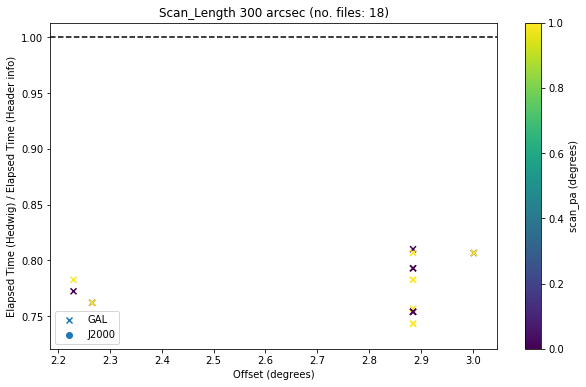

In [ ]:

if projname == 'ec07':
    datafilesbysize = datafile.group_by('Scan_Length')
    for x in (datafilesbysize.groups.keys):
        width = x['Scan_Length']
        PlotOffsetRelTime(datafile, width, projname)

if projname == 'm17bl004':
    datafilesbysize = datafile.group_by('Scan_Length') # split up data by map size (specifically Scan_Length not Map_wdth)
    for x in (datafilesbysize.groups.keys): # for each map size
        width = x['Scan_Length'] # for a particular map width
        PlotOffsetRelTime(datafile, width, projname) # plot PlotOffsetRelTime 

        
        
# PlotOffsetRelTime(datafile, 300, projname) # old method
# PlotOffsetRelTime(datafile, 1260, projname)
# datafilesbysize.groups.keys

In [ ]:
# if projname == 'ec07':
#     for x in (datafilesbysize.groups.keys):
#         width = x['Scan_Length']
#         PlotOffsetAbsTime(datafile, width, projname)
    
# if projname == 'm17bl004':
#     for x in (datafilesbysize.groups.keys):
#         width = x['Scan_Length']
#         PlotOffsetAbsTime(datafile, width, projname)

In [ ]:

print(np.ceil(0.1))